# Ecuación de calor 1D - estacionario

En este notebook se explica la construcción numérica de la solución de la ecuación de calor unidimensional en estado estacionario, con presencia de un sumidero que depende linealmente de la temperatura

$$k\frac{d^2T}{dx^2} - \lambda T=0$$

Con: $S = \lambda T$

La ecuacion está sujeta a: 

$$T(x_0) = T_0$$
$$T(x_L) = T_L$$

En este caso, el término $S$ está condicionado al valor de la temperatura en el dominio, y la solución cambiará respecto a cuando el término $S$ es una constante cualquiera. 

## Solución exacta: 

Para la solución exacta, se procede a resolver el polinomio característico de la ecuación, para encontrar la función solución. En este caso, supondremos que la solución tiene forma de $T(x) = ae^{bx}$.

Después de hacer un poco de ejercicio con la ecuación, se obtiene que la solución de la ecuación diferencial es: 

$$T(x)= T_0 cosh(m_1x) + \frac{T_L - T_0 cosh(m_1L)}{senh(m_1L)}senh(m_1x)$$

Haciendo que $m_1=\sqrt{\frac{\lambda}{k}}$

Vamos a suponer los siguientes valores del problema para poder graficar la solución asociada al mismo: 

- Longitud: $L = 1,0 m$
- Conductividad térmica: $k = 1,0 W/mK$
- $\lambda=0.1\ m^{-2}$
- Temperatura en la frontera izquierda: $300\ K$
- Temperatura en la frontera derecha: $200\ K$

In [232]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Declarando las variables iniciales para el problema
L = 1.0                    # Longitud de la barra
T0 = 300.0                 # Condición de contorno en x=0 (K)
TL = 260.0                 # Condición de contorno en x=L (K)
k = 1.0                    # Conductividad térmica (W/mK)
Lambda = 0.3               # Término de pérdida de calor (W/m^2K)

In [233]:
# Función que calcula la solución analítica del problema propuesto
def solucion_analitica(x, T0, TL, L, Lambda, K):

    # Número característico de la solución
    m1 = np.sqrt(Lambda / k)

    # Constantes de las funciones hiperbólicas
    A = T0
    B = (TL - T0 * np.cosh(m1 * L)) / np.sinh(m1 * L)

    # Calculando la temperatura en los diferentes puntos
    T = A * np.cosh(m1 * x) + B * np.sinh(m1 * x)
    
    return T

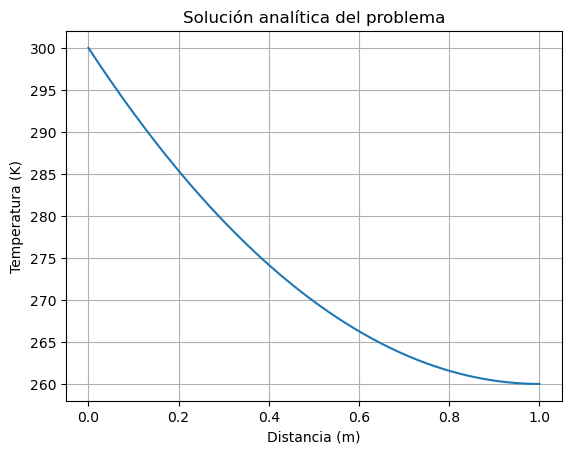

In [234]:
# Graficando la solución analítica del problema
x = np.linspace(0, 1, 200)
T = solucion_analitica(x, T0, TL, L, Lambda, k)

plt.plot(x, T)
plt.title('Solución analítica del problema')
plt.xlabel('Distancia (m)')
plt.ylabel('Temperatura (K)')
plt.grid()

## Construcción de la solución numérica

Habiendo visto la solución analítica del problema, procedemos a montar la solución numérica con el método de los volúmenes de control, propuesto en las clases y estudiado. 

Como sabemos, la ecuación que deseamos solucionar es de la forma: 

$$k\frac{d^2T}{dx^2} - \lambda T = 0$$

Si se integra con respecto a $x$ en un volumen finito, se obtiene: 

$$k\frac{T_E-T_P}{(\delta x)_e} - k\frac{T_P-T_W}{(\delta x)_w}-\int_w^e\lambda T dx = 0$$

O en otras palabras: 

$$k\frac{T_E-T_P}{(\delta x)_e} - k\frac{T_P-T_W}{(\delta x)_w}-\lambda T \Delta x = 0$$

Donde $\Delta x$ es el tamaño del volumen de control que se está tomando. Recuerde que, por facilidad, cada una de las caras del volumen de control se encuentra a medio camino entre dos nodos. Ahora bien, con estas distribuciones se puede escribir la ecuación de cada uno de los nodos internos como: 

$$a_ET_E+a_WT_W-a_PT_P= 0$$

Los valores de los coficientes $a$ serán: 

$$a_E=\frac{k}{(\delta x)_e}$$
$$a_W=\frac{k}{(\delta x)_w}$$
$$a_P = -(a_E + a_W) - \lambda \Delta x$$


In [235]:
# Espaciamiento entre nodos que se selecciona
dx = 0.25                    # Tamaño de paso en x (m)

# Cantidad de nodos en la solución numérica
nx = int(L / dx) + 1

# Construyendo el vector del espacio para los nodos
x = np.linspace(0, L, nx)

# Construcción de la matriz de coeficientes que se solucionará
A = np.zeros((nx, nx))
b = np.zeros(nx)

# Llenando la matriz de coeficientes y el vector de términos independientes
for i in range(1, nx - 1):

    # Calculando el deltax, que puede ser no equiespaciado
    deltax = (x[i + 1] - x[i - 1]) / 2

    # Términos de la matriz
    A[i, i - 1] = k / (x[i] - x[i - 1])
    A[i, i + 1] = k / (x[i + 1] - x[i])
    A[i, i] = -(A[i, i - 1] + A[i, i + 1]) - Lambda * deltax

# Llenamos ahora las condiciones de contorno del problema
A[0, 0] = 1
A[nx - 1, nx - 1] = 1
b[0] = T0
b[-1] = TL

# Resolvemos el sistema lineal (luego lo haremos a manito)
T = np.linalg.solve(A, b)

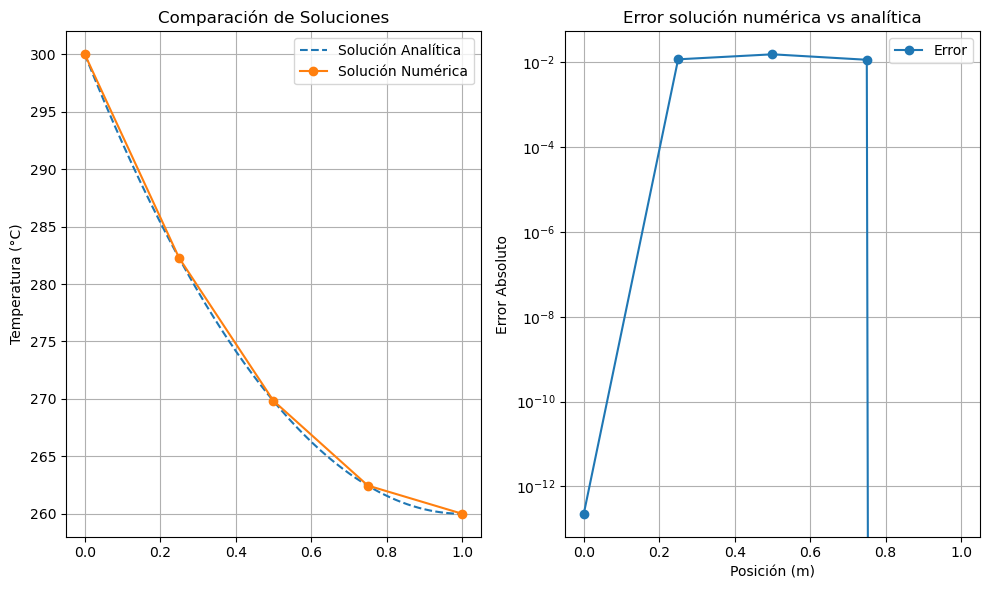

In [236]:
# Generando gráfica de solución analítica superpuesta a numérica y
# un panel con el error en cada uno de los puntos
T_an = solucion_analitica(x, T0, TL, L, Lambda, k)
Error = np.abs(T_an - T)

# Gráfica suavizada de la solución analítica
xS = np.linspace(0, L, 200)
Ts = solucion_analitica(xS, T0, TL, L, Lambda, k)

# Figura con las dos curvas y los errores
fig, ax = plt.subplots(1, 2, figsize=(10, 6))

# Gráfica de la solución analítica y numérica
ax[0].plot(xS, Ts, label='Solución Analítica', ls='--')
ax[0].plot(x, T, label='Solución Numérica', marker='o')
ax[0].set_title('Comparación de Soluciones')
ax[0].set_ylabel('Temperatura (°C)')
ax[0].legend()
ax[0].grid()

# Gráfica del error entre las soluciones
ax[1].semilogy(x, Error, label = 'Error', marker='o')
ax[1].set_title('Error solución numérica vs analítica')
ax[1].set_ylabel('Error Absoluto')
ax[1].set_xlabel('Posición (m)')
ax[1].grid()
ax[1].legend()

# Cuadrando de forma automática el display de la figura
plt.tight_layout()
plt.show()

In [237]:
# Decimales a mostrar en la solución: 
decimales = 4

# Creando y mostrando un dataframe con los valores del problema
dataframe = pd.DataFrame({
    'Posición (m)': x,
    'Solución analítica (K)': np.round(T_an, decimales),
    'Solución numérica (K)': np.round(T, decimales),
    'Error absoluto (K)': np.round(Error, decimales + 2), 
    'Error relativo (%)': np.round(Error / T_an * 100, decimales + 3)
})

# Haciendo la posición el índice del dataframe
dataframe.set_index('Posición (m)', inplace=True)

# Mostrando el dataframe
dataframe

,Solución analítica (K),Solución numérica (K),Error absoluto (K),Error relativo (%)
Posición (m),,,,
0.00,300.0000,300.0000,0.000000,0.000000
0.25,282.2589,282.2706,0.011721,0.004153
0.50,269.8184,269.8338,0.015388,0.005703
0.75,262.4449,262.4564,0.011434,0.004357
1.00,260.0000,260.0000,0.000000,0.000000


## Caso no lineal: 

Hay veces que, por ejemplo, el coeficiente $k$ depende de la temperatura a la que se encuentra el medio. En otro tipo de problemas, como el de la difusión de contaminantes, esto se puede asociar con que la difusividad depende de la concentración de contaminante en el agua. Para ese tipo de casos, se requiere hacer un proceso iterativo que ayude a determinar el valor de la temperatura en el medio. La ecuación que estamos buscando resolver es la siguiente: 

$$\frac{d}{dx}\Bigg(k(T)\frac{dT}{dx}\Bigg) - S = 0$$

Para efectos del ejercicio, vamos a asumir que la conductividad térmica está asociada con la temperatura de forma lineal, de la siguiente manera: 

$$k(T)=\beta T$$

Acá volveremos a hacer lo necesario en el proceso de integración para ver qué es lo que está pasando. Para simplificar el proceso, haremos que el término S vuelva a ser una constante. Sin embargo, si existiera una dependencia de la forma $S = f(T)$, el tratamiento sería una superposición con el caso visto anteriormente. 

## Planteamiento numérico de la solución

Si se integra la ecuación diferencial, se obtiene la siguiente expresión:

$$\Bigg(\beta T_P \frac{T_E-T_P}{(\delta x)_e}\Bigg)-\Bigg(\beta T_P \frac{T_P-T_W}{(\delta x)_w}\Bigg) - S \Delta x = 0$$

Al agrupar los términos se puede ver que resulta un sistema no lineal, que debe ser resuelto por medio de un proceso iterativo. 

$$a_ET_E+a_PT_P+a_WT_W - b = 0$$

$$a_E=\frac{\beta T_P^*}{(\delta x)_e}$$
$$a_W=\frac{\beta T_P^*}{(\delta x)_w}$$
$$a_P = -(a_E+a_W)$$
$$b = S \Delta x$$

Para la solución se procederá suponiendo un valor de $T$, denominado $T^*$ en todos los puntos del dominio. Con ese valor se calcularán los coeficientes de la matriz, se resolverá el sistema para hallar un nuevo valor de $T$, que se comparará con el supuesto. El proceso se repetirá hasta que el valor de $T$ nuevo sea muy cercano al $T$ del paso anterior. 

In [249]:
# Poniendo el valor del coeficente beta 
beta = 3e-4                      # Valor del coeficiente beta
S = -5.                          # Fuente/Sumidero de calor

# Parámetros numéricos del solver
err = 1e10                      # Error inicial (muy grande)
tol = 1e-6                      # Tolerancia
count = 1                       # Contando iteraciones

# Supongo las temperaturas iniciales para todo el dominio
T_0 = np.ones_like(x) * 0.5 * (T0 + TL)

# Armando la matriz y el vector de mano derecha (en las partes que no cambian)
A = np.zeros((nx, nx))
b = np.zeros(nx)

# Llenando la matriz en los contornos
A[0, 0] = 1
A[-1, -1] = 1

# Llenando el vector de mano derecha con la información de contorno
b[0] = T0
b[-1] = TL
for i in range(1, nx - 1): b[i] = -S * (x[i + 1] - x[i - 1]) / 2

# Proceso iterativo para hallar solución
while err > tol: 

    # Llenar la matriz con los valores supuestos de T
    for i in range(1, nx - 1): 
        A[i, i - 1] = beta * T_0[i] / (x[i] - x[i - 1])
        A[i, i + 1] = beta * T_0[i] / (x[i + 1] - x[i])
        A[i, i] = -(A[i, i - 1] + A[i, i + 1])

    # Resolviendo el sistema lineal
    T_1 = np.linalg.solve(A, b)

    # Calculando el error de la solución
    err = np.linalg.norm(T_1 - T_0)

    # Imprimiendo información de progreso
    print('Iteración {}:\tError = {:.4f}'.format(count, err))
    print('T_1 = {}'.format(np.round(T_1, 4)))

    # Actualizando el valor de la solución
    T_0 = T_1

    # Actualizando el contador
    count += 1

Iteración 1:	Error = 33.4311
T_1 = [300.     284.4196 272.5595 264.4196 260.    ]
Iteración 2:	Error = 0.2782
T_1 = [300.     284.3574 272.3773 264.2189 260.    ]
Iteración 3:	Error = 0.0064
T_1 = [300.     284.3548 272.3728 264.2152 260.    ]
Iteración 4:	Error = 0.0002
T_1 = [300.     284.3547 272.3727 264.2151 260.    ]
Iteración 5:	Error = 0.0000
T_1 = [300.     284.3547 272.3727 264.2151 260.    ]
Iteración 6:	Error = 0.0000
T_1 = [300.     284.3547 272.3727 264.2151 260.    ]


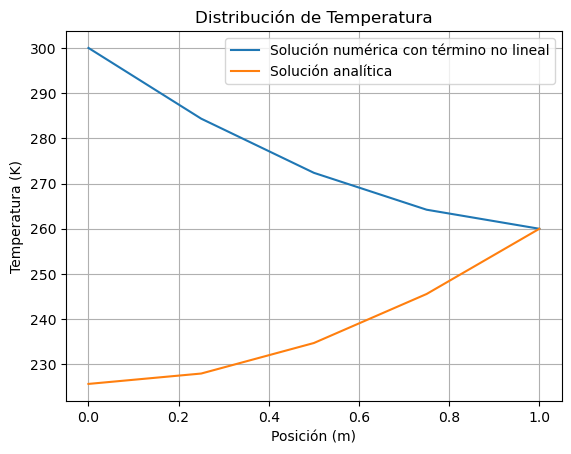

In [250]:
#  Solución analítica del problema:
def analitica_nl(T0, TL, S, beta, L, x):
    
    # Calculando las constantes
    C2 = (beta * T0 ** 2) / 2
    C1 = S * L / 2 + (TL ** 2 - T0 ** 2) * (0.5 * beta / L) 

    # Calculando el valor de temperatura
    T = np.sqrt((-S * x ** 2 + 2 * (C1 + C2)) / beta)

    return T

T_an = analitica_nl(T0, TL, S, beta, L, x)

# Graficando con errores 
plt.plot(x, T_1, label='Solución numérica con término no lineal')
plt.plot(x, T_an, label='Solución analítica')
plt.xlabel('Posición (m)')
plt.ylabel('Temperatura (K)')
plt.title('Distribución de Temperatura')
plt.grid()
plt.legend()
plt.show()